# Setup Loop Simulations
Using the EBTEL model, configure loop simulations, including various heating profiles, for a few different heating scenarios based on the inputs from the chosen active region.

In [22]:
import os
import copy
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
import astropy.constants as const

import synthesizAR
from synthesizAR.model_ext import (EbtelInterface, PowerLawScaledWaitingTimes)

%matplotlib inline

## Heating Function and Properties

We want to configure three different heating functions:
* low-frequency
* intermediate-frequency
* high-frequency

The frequency will be set by the average waiting time between events, $\bar{t}_N$, and the waiting time *prior to* each event will scale linearly with the energy released by that event such that $t_{N,i}\propto Q_i$. 

To implement this heating function, we only need to subclass the existing `PowerLawScaledWaitingTimes` model and override the `_calculate_start_times` method such that the wait time is prior to rather than after the event.

In [2]:
class NanoflareTrain(PowerLawScaledWaitingTimes):
    
    def _calculate_start_times(self,rates):
        scaling_constant = self._calculate_scaling_constant(rates)
        time_start_rise = np.empty([self.number_events])
        wait_time_sum = 0.0
        for i in range(self.number_events):
            wait_time_sum += ((rates[i]**(1.0/self.heating_options['waiting_time_scaling']))
                              / scaling_constant)
            time_start_rise[i] = i*self.heating_options['duration'] + wait_time_sum
        
        return time_start_rise


Now, set some of the base properties for the heating. For now, set the average waiting time to None. It will be configured separately for each heating model.

In [4]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'average_waiting_time':None,
    'waiting_time_scaling':1.0
}

## Estimate Average Cooling Times
In our high, intermediate, and low frequency cases, we want the time between heating events to be much less, about the same, and greater than a loop cooling time, respectively. To determine these values, we want to estimate the cooling times for the loops in our active region.

First, import the field object.

In [5]:
field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/base_noaa1109/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-03-20 23:09:22,588 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-03-20 23:09:22,588 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-03-20 23:09:22,590 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-03-20 23:09:22,591 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-03-20 23:09:22,592 Parameters: cosmological_simulation   = 0.0


From Eq. A2 of Cargill (2014), we can estimate the loop cooling time as,

$$
\tau_{cool} = \left(\frac{2-\alpha}{1-\alpha}\right)3k_B\left(\frac{L^{8-4\alpha}}{\kappa_0^{4-2\alpha}\chi^7(n_0T_0)^{3+2\alpha}}\right)^{1/(11-2\alpha)}
$$

We'll assume $\alpha=-1/2$, $\chi=6\times10^{-20}$, $n_0=5\times10^9$ cm$^{-3}$, and $T_0=10^7$ K.

In [6]:
def calculate_cooling_time(loop_length):
    alpha=-0.5
    chi = 6e-20
    T0 = 5.e6
    n0 = 1.e10
    kappa = 8.12e-7
    
    term1 = (2 - alpha)/(1 - alpha)
    term2 = loop_length**(8 - 4*alpha)
    term3 = (kappa**(4-2*alpha))*(chi**7)*((n0*T0)**(3+2*alpha))
    
    return term1*3.*const.k_B.cgs.value*((term2/term3)**(1./(11.-2.*alpha)))

In [7]:
cooling_times = list(map(calculate_cooling_time,[loop.full_length.value/2. for loop in field.loops]))

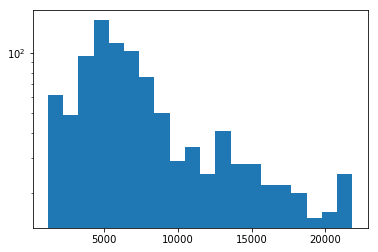

In [8]:
plt.hist(cooling_times,20)
plt.yscale('log')

In [9]:
print(np.min(cooling_times),np.max(cooling_times))

1212.42803896 21821.1346514


The distribution of cooling times ranges all the way from ~1000 s to >20000 s, with a peak near 5000 s. We'll use the following values for our high, intermediate, and low frequency heating cases:

| Case | $\bar{t}_N$ (s) |
|:----:|:-----------:|
| low frequency | 5000 |
| intermediate frequency | 2500 |
| high frequency | 750 |

## Configure Models
We'll now configure each of the models, using the AR 1109 base model as a starting point each time. We'll derive the base properties of the simulation from the default ebtel++ configuration. In all cases, the simulations will last a total of 20000 s and the total energy injected into each strand will depend on the local field strength. In all the cases considered here, we are heating only the electrons.

In [16]:
ih = synthesizAR.util.InputHandler(os.path.join('/home/wtb2/Documents/codes',
                                                'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 22000.0
base_config['use_flux_limiting'] = True
base_config['heating']['background'] = 1e-6
base_config['heating']['partition'] = 1.0

### Low-frequency Model

First, configure heating and setup model interface.

In [17]:
heating_options_low = copy.deepcopy(heating_options)
heating_options_low['average_waiting_time'] = 5000.0

In [18]:
heating_model_low = NanoflareTrain(heating_options_low)

In [19]:
ebtel_interface_low = EbtelInterface(base_config,heating_model_low,
                            '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_low_frequency/hydro_config/',
                            '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_low_frequency/hydro_results/')

Next, setup a new field object from the base field object and configure all of the loop simulations.

In [20]:
field_noaa1109_low = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/base_noaa1109/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-03-20 23:14:14,023 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-03-20 23:14:14,024 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-03-20 23:14:14,025 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-03-20 23:14:14,026 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-03-20 23:14:14,026 Parameters: cosmological_simulation   = 0.0


In [21]:
field_noaa1109_low.configure_loop_simulations(ebtel_interface_low)

Power-law constrainer reached max # of tries, using best guess with error = 0.001064017721863264
Power-law constrainer reached max # of tries, using best guess with error = 0.0010583534682218065
Power-law constrainer reached max # of tries, using best guess with error = 0.0016054042226356646
Power-law constrainer reached max # of tries, using best guess with error = 0.0023003490886803757
Power-law constrainer reached max # of tries, using best guess with error = 0.001032967894279313
Power-law constrainer reached max # of tries, using best guess with error = 0.001318719593820128
Power-law constrainer reached max # of tries, using best guess with error = 0.001599787746576542
Power-law constrainer reached max # of tries, using best guess with error = 0.0013817901474730832
Power-law constrainer reached max # of tries, using best guess with error = 0.0011548762881556929
Power-law constrainer reached max # of tries, using best guess with error = 0.0017976664643954976
Power-law constrainer re

and then run all of the simulations.

In [24]:
for loop in field_noaa1109_low.loops:
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

Finally, read all of the loop results in and save the model.

In [25]:
field_noaa1109_low.load_loop_simulations(ebtel_interface_low,
                                         savefile='/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_low_frequency/loop_parameters.h5')

In [26]:
field_noaa1109_low.save(savedir='/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_low_frequency/field_checkpoint')

(0, 22000.0)

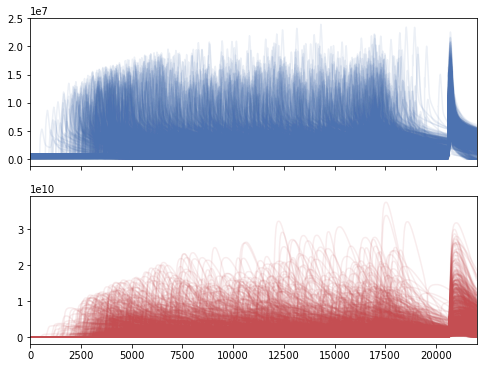

In [37]:
fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True)
for i in range(0,1000,1):
    axes[0].plot(field_noaa1109_low.loops[i].time,
                 field_noaa1109_low.loops[i].temperature[:,0],
                 color=sns.color_palette('deep')[0],
                 alpha=0.1)
    axes[1].plot(field_noaa1109_low.loops[i].time,
                 field_noaa1109_low.loops[i].density[:,0],
                 color=sns.color_palette('deep')[2],
                 alpha=0.1)
axes[0].set_xlim([0,2.2e4])

### Intermediate-frequency Model

In [45]:
heating_options_intermediate = copy.deepcopy(heating_options)
heating_options_intermediate['average_waiting_time'] = 2500.0

In [46]:
heating_model_intermediate = NanoflareTrain(heating_options_intermediate)

In [47]:
ebtel_interface_intermediate = EbtelInterface(base_config,heating_model_intermediate,
                                 '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_intermediate_frequency/hydro_config/',
                                 '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_intermediate_frequency/hydro_results/')

In [48]:
field_noaa1109_intermediate = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/base_noaa1109/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-03-21 11:55:41,848 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-03-21 11:55:41,849 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-03-21 11:55:41,851 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-03-21 11:55:41,852 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-03-21 11:55:41,853 Parameters: cosmological_simulation   = 0.0


In [49]:
field_noaa1109_intermediate.configure_loop_simulations(ebtel_interface_intermediate)

Power-law constrainer reached max # of tries, using best guess with error = 0.0013749047005509052
Power-law constrainer reached max # of tries, using best guess with error = 0.001167357102051625
Power-law constrainer reached max # of tries, using best guess with error = 0.001284659473924421
Power-law constrainer reached max # of tries, using best guess with error = 0.001303945941802942
Power-law constrainer reached max # of tries, using best guess with error = 0.0014039982639071358
Power-law constrainer reached max # of tries, using best guess with error = 0.0015554580742831448
Power-law constrainer reached max # of tries, using best guess with error = 0.0011398330864204054
Power-law constrainer reached max # of tries, using best guess with error = 0.001190526277081494
Power-law constrainer reached max # of tries, using best guess with error = 0.002001991451701657
Power-law constrainer reached max # of tries, using best guess with error = 0.0011254952271796403
Power-law constrainer rea

In [50]:
for loop in field_noaa1109_intermediate.loops:
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [51]:
field_noaa1109_intermediate.load_loop_simulations(ebtel_interface_intermediate,
        savefile='/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_intermediate_frequency/loop_parameters.h5')

In [52]:
field_noaa1109_intermediate.save(savedir='/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_intermediate_frequency/field_checkpoint')

(0, 22000.0)

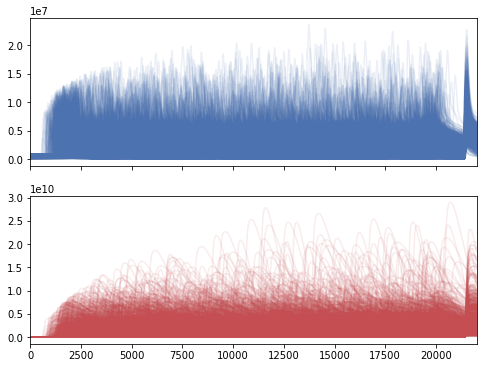

In [57]:
fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True)
for i in range(0,1000,1):
    axes[0].plot(field_noaa1109_intermediate.loops[i].time,
                 field_noaa1109_intermediate.loops[i].temperature[:,0],
                 color=sns.color_palette('deep')[0],
                 alpha=0.1)
    axes[1].plot(field_noaa1109_intermediate.loops[i].time,
                 field_noaa1109_intermediate.loops[i].density[:,0],
                 color=sns.color_palette('deep')[2],
                 alpha=0.1)
axes[0].set_xlim([0,2.2e4])

### High-frequency Model

In [59]:
heating_options_high = copy.deepcopy(heating_options)
heating_options_high['average_waiting_time'] = 750.0

In [60]:
heating_model_high = NanoflareTrain(heating_options_high)

In [61]:
ebtel_interface_high = EbtelInterface(base_config,heating_model_high,
                                 '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_high_frequency/hydro_config/',
                                 '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_high_frequency/hydro_results/')

In [62]:
field_noaa1109_high = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/base_noaa1109/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-03-21 12:46:25,211 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-03-21 12:46:25,213 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-03-21 12:46:25,214 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-03-21 12:46:25,215 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-03-21 12:46:25,216 Parameters: cosmological_simulation   = 0.0


In [63]:
field_noaa1109_high.configure_loop_simulations(ebtel_interface_high)

Power-law constrainer reached max # of tries, using best guess with error = 0.0011027640805114647
Power-law constrainer reached max # of tries, using best guess with error = 0.0013763990003134996
Power-law constrainer reached max # of tries, using best guess with error = 0.0012225490768617009
Power-law constrainer reached max # of tries, using best guess with error = 0.0011105117294010203
Power-law constrainer reached max # of tries, using best guess with error = 0.0011142304872575615
Power-law constrainer reached max # of tries, using best guess with error = 0.0011180858186897735
Power-law constrainer reached max # of tries, using best guess with error = 0.0014720534677934438
Power-law constrainer reached max # of tries, using best guess with error = 0.0011576941694235732
Power-law constrainer reached max # of tries, using best guess with error = 0.0010203638711165919
Power-law constrainer reached max # of tries, using best guess with error = 0.0010057435701292805
Power-law constraine

In [64]:
for loop in field_noaa1109_high.loops:
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [65]:
field_noaa1109_high.load_loop_simulations(ebtel_interface_high,
        savefile='/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_high_frequency/loop_parameters.h5')

In [66]:
field_noaa1109_high.save(savedir='/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_high_frequency/field_checkpoint')

(0, 22000.0)

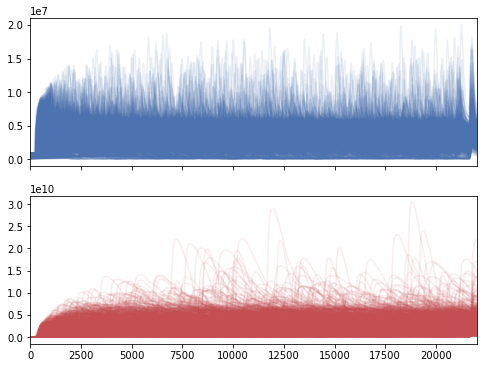

In [70]:
fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True)
for i in range(0,1000,1):
    axes[0].plot(field_noaa1109_high.loops[i].time,
                 field_noaa1109_high.loops[i].temperature[:,0],
                 color=sns.color_palette('deep')[0],
                 alpha=0.1)
    axes[1].plot(field_noaa1109_high.loops[i].time,
                 field_noaa1109_high.loops[i].density[:,0],
                 color=sns.color_palette('deep')[2],
                 alpha=0.1)
axes[0].set_xlim([0,2.2e4])

In [73]:
!ls /data/datadrive1/ar_forward_modeling/systematic_ar_study/

base_noaa1109  emission_model1109		noaa1109_low_frequency
base_noaa1193  noaa1109_high_frequency
chianti_db.h5  noaa1109_intermediate_frequency
